In [1]:
#Importing drive model from the google.colab package
from google.colab import drive

#Mounting the google drive to a specific path
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection

/content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection


In [3]:
# Configuring Git user details
!git config --global user.email "dorothy.sarpongk@gmail.com"
!git config --global user.name "01DorSarpong"

In [4]:
# Importing libraries for code

import pandas as pd
import numpy  as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from typing import Tuple, Union


In [5]:
# A function to download and save FTSE 100 and FTSE 250 stocks

def download_and_save_FTSE_stocks(tickers: list, start_date: str, end_date: str, directory: str):

 """ This function downloads historical stock data for a list of tickers and saves it to CSV files.

  Args:
    tickers_list (list): A list of stock ticker symbols (e.g., ['TSCO.L', 'BARC.L']).
    start_date (str): The start date for data download in 'YYYY-MM-DD' format.
    end_date (str): The end date for data download in 'YYYY-MM-DD' format.
    directory (str): The path to the directory where CSV files will be saved.
  """

  # Ensure the save directory exists
 if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")

 print(f"Starting download for {len(tickers)} tickers from {start_date} to {end_date}...")

 for ticker in tqdm(tickers, desc="Downloading Stocks"):
    # Format the filename: remove '.L' and add date range for clarity
    cleaned_ticker = ticker.replace('.L', '')
    file_name = f"{cleaned_ticker}_{start_date.replace('-', '')}_{end_date.replace('-', '')}.csv"
    full_file_path = os.path.join(directory, file_name)

    try:
      df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

      if not df.empty:
        df.to_csv(full_file_path)
        # print(f"✅ Saved data for {ticker} to {full_file_path}") # Optional: uncomment for more verbose output
      else:
        print(f"⚠️ No data available for {ticker} for the specified period.")
    except Exception as e:
      print(f"❌ Error downloading or saving data for {ticker}: {e}")

 print("Download process completed.")


In [6]:
#Creating a list of FTSE 100 and FTSE 250 tickers

FTSE_100_tickers = ["AZN.L", "HSBA.L", "ULVR.L", "REL.L", "BATS.L", "BP.L", "GSK.L", "DGE.L",
                   "RR.L", "NG.L", "BARC.L", "TSCO.L", "PRU.L", "BHP.L", "BT-A.L",]

FTSE_250_tickers = ["BWY.L", "EMG.L", "JUST.L", "SXS.L", "CKN.L", "LRE.L", "RAT.L", "THG.L",
                    "JDW.L", "SCT.L", "DOM.L", "SRE.L", "HIK.L", "ICGT.L", "HSX.L"]

In [7]:
#Defining the period for stocks range
start_date = "2014-01-01"
end_date = "2024-12-31"

In [8]:
# Defining the path to save the CSVs

ftse_100_path = '/content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection/FTSE_100'
ftse_250_path = '/content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection/FTSE_250'


In [9]:
# Calling the function for FTSE 100 and FTSE 250 tickers

download_and_save_FTSE_stocks(
    tickers=FTSE_100_tickers,
    start_date=start_date,
    end_date=end_date,
    directory=ftse_100_path
)

download_and_save_FTSE_stocks(
    tickers=FTSE_250_tickers,
    start_date=start_date,
    end_date=end_date,
    directory=ftse_250_path
)

Starting download for 15 tickers from 2014-01-01 to 2024-12-31...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Download process completed.
Starting download for 15 tickers from 2014-01-01 to 2024-12-31...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Download process completed.


In [10]:
# Creating a function to load stocks and pre-process into a dataframe

def load_and_structure_stock_data(folder_path: str) -> pd.DataFrame:
    """
    Loads historical stock data from CSV files in a specified folder,
    cleans, processes, filters to weekdays, fills NaNs/gaps, and
    consolidates them into a single structured DataFrame with a MultiIndex.

    Args:
        folder_path (str): The path to the directory containing stock data CSVs.

    Returns:
        pd.DataFrame: A single DataFrame containing data for all tickers,
                      indexed by 'Date' and 'Ticker', sorted by Date and then Ticker.
                      Returns an empty DataFrame if no data is loaded or processed.
    """
    all_dfs = []

    if not os.path.exists(folder_path):
        print(f"❌ Error: Folder not found at {folder_path}")
        return pd.DataFrame() # Return empty DataFrame if folder doesn't exist

    # Get list of CSV files to process
    file_list = [f.name for f in os.scandir(folder_path) if f.name.endswith(".csv")]

    if not file_list:
        print(f"⚠️ No CSV files found in {folder_path}")
        return pd.DataFrame()

    print(f"Loading and processing data from {len(file_list)} CSV files in {folder_path}...")

    # Define columns that typically contain numerical stock data to be filled
    numerical_cols_to_fill = ['open', 'high', 'low', 'close', 'adj close', 'volume']

    for filename in tqdm(file_list, desc="Processing Stock Files"):
        file_path = os.path.join(folder_path, filename)

        try:
            # Read CSV: use first row as header, skip second row (often contains ticker name repeated)
            df = pd.read_csv(file_path, header=0, skiprows=[1], encoding='utf-8-sig')

            # --- Initial Cleaning and Date Conversion ---
            # Rename the first column to 'Date' if it's not already
            if df.columns[0].strip().lower() != 'date':
                df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

            # Normalize all column names to lowercase and remove leading/trailing spaces
            df.columns = [col.strip().lower() for col in df.columns]

            # Clean and prepare the 'date' column
            df['date'] = df['date'].astype(str).str.strip()
            df = df[df['date'].str.lower() != 'date'] # Drop any rows where the date column contains the string 'Date'

            # Convert to datetime, coercing errors will turn unparseable dates into NaT
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df.dropna(subset=['date'], inplace=True) # Drop rows where date conversion failed (NaT)

            # --- Add Ticker Information ---
            # Extract ticker from filename (e.g., 'TSCO_20140101_20241231.csv' -> 'TSCO')
            ticker_symbol = filename.split('_')[0]
            df['ticker'] = ticker_symbol

            # --- Set Date as Index (temporarily for filtering/filling) ---
            df.set_index('date', inplace=True)

            # --- Filter for Weekdays Only ---
            # .dayofweek returns Monday=0, ..., Sunday=6. Keep only 0 to 4.
            df = df[df.index.dayofweek < 5]

            # --- Fill NaNs/Gaps for Numerical Columns ---
            # Identify columns to fill that actually exist in the current DataFrame
            existing_numerical_cols = [col for col in numerical_cols_to_fill if col in df.columns]

            if not existing_numerical_cols:
                # print(f"⚠️ No numerical columns found for {filename}. Skipping NaN filling for this file.")
                pass # This is fine, just means the file might only have non-numerical data or very specific columns

            # Apply forward-fill then backward-fill for numerical columns within this ticker's data
            # This handles gaps for individual stock series
            df[existing_numerical_cols] = df[existing_numerical_cols].ffill().bfill()

            # --- Final Check for essential data after filling ---
            # If 'open' column is vital and still has NaNs (e.g., entire series was NaN), drop those rows
            if 'open' in df.columns:
                df.dropna(subset=['open'], inplace=True)
            else:
                print(f"⚠️ 'open' column not found in {filename}. Skipping this file as essential data is missing.")
                continue # Skip this file if 'open' is genuinely missing

            if df.empty:
                print(f"⚠️ No valid weekday data remaining for {filename} after filtering. Skipping.")
                continue

            all_dfs.append(df)

        except pd.errors.EmptyDataError:
            print(f"⚠️ {filename} is empty. Skipping.")
        except pd.errors.ParserError as e:
            print(f"❌ Error parsing {filename}: {type(e).__name__} - {e}. Skipping.")
        except Exception as e:
            print(f"❌ Error processing {filename}: {type(e).__name__} - {e}. Skipping.")

    if not all_dfs:
        print("No valid stock data loaded after processing. Returning empty DataFrame.")
        return pd.DataFrame()

    # --- Consolidate all DataFrames into one structured DataFrame ---
    combined_df = pd.concat(all_dfs)

    # Set a MultiIndex: primary index is 'Date', secondary is 'ticker'
    # 'ticker' was added as a regular column inside the loop, now it becomes part of the index
    combined_df.set_index('ticker', append=True, inplace=True)
    combined_df.index.names = ['Date', 'Ticker']

    # Sort the MultiIndex for better performance and consistency
    combined_df.sort_index(inplace=True)

    print("All stock data loaded, structured, filtered, and filled successfully.")
    return combined_df



In [11]:
#Calling the function to load and structure df for FTSE 100 stocks

ready_ftse100_data = load_and_structure_stock_data(ftse_100_path)

if not ready_ftse100_data.empty:
  print("\n--- Final Structured and Cleaned DataFrame ---")
  print(ready_ftse100_data.head(15)) # Show more rows to see multiple dates/tickers
  print("\nDataFrame Info:")
  ready_ftse100_data.info()
  print("\nSample of weekdays (should only be Mon-Fri):")
  print(ready_ftse100_data.index.get_level_values('Date').day_name().value_counts())
  print("\nNaNs after processing (should be very few or none in numerical columns):")
  print(ready_ftse100_data.isnull().sum())
else:
 print("No data was successfully loaded and processed.")

Loading and processing data from 15 CSV files in /content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection/FTSE_100...


Processing Stock Files: 100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


All stock data loaded, structured, filtered, and filled successfully.

--- Final Structured and Cleaned DataFrame ---
                     adj close        close         high          low  \
Date       Ticker                                                       
2014-01-02 AZN     3544.462402  3558.000000  3592.500000  3545.500000   
           BARC     270.183594   271.049988   274.651001   268.350006   
           BATS    3185.133057  3207.500000  3252.500000  3207.000000   
           BHP     1842.533936  1852.000000  1877.000000  1835.000000   
           BP       485.673065   488.850006   490.950012   484.649994   
           BT-A     378.285339   380.100006   383.299988   376.899994   
           DGE     1978.446533  1984.000000  2010.500000  1977.500000   
           GSK     1600.524048  1611.268677  1628.393677  1609.253906   
           HSBA     656.087158   659.700012   661.200012   654.599976   
           NG       858.876831   859.635986   864.545105   853.635986   
      

In [12]:
#Calling the function to load and structure df for FTSE 250 stocks

ready_ftse250_data = load_and_structure_stock_data(ftse_250_path)

if not ready_ftse250_data.empty:
  print("\n--- Final Structured and Cleaned DataFrame ---")
  print(ready_ftse250_data.head(15)) # Show more rows to see multiple dates/tickers
  print("\nDataFrame Info:")
  ready_ftse250_data.info()
  print("\nSample of weekdays (should only be Mon-Fri):")
  print(ready_ftse250_data.index.get_level_values('Date').day_name().value_counts())
  print("\nNaNs after processing (should be very few or none in numerical columns):")
  print(ready_ftse250_data.isnull().sum())
else:
 print("No data was successfully loaded and processed.")

Loading and processing data from 15 CSV files in /content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection/FTSE_250...


Processing Stock Files: 100%|██████████| 15/15 [00:00<00:00, 22.08it/s]


All stock data loaded, structured, filtered, and filled successfully.

--- Final Structured and Cleaned DataFrame ---
                     adj close        close         high          low  \
Date       Ticker                                                       
2014-01-02 BWY     1598.919189  1606.000000  1606.000000  1555.000000   
           CKN     1994.517456  2001.000000  2049.399902  2010.000000   
           DOM      168.826324   169.333298   173.666595   169.333298   
           EMG       85.495476    86.000000    86.750000    82.900002   
           HIK     1275.063477  1277.000000  1283.000000  1213.000000   
           HSX      882.262634   884.192993   892.492310   881.000977   
           ICGT     583.726685   585.500000   598.000000   585.500000   
           JDW      766.257996   767.000000   767.000000   751.500000   
           JUST     209.640976   210.000000   212.000000   201.500000   
           LRE      805.188599   811.000000   815.000000   801.500000   
      

In [13]:
# A function to genereate the stock features needed to build ML model

def generate_all_stock_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates a comprehensive set of time-series and cross-sectional numerical features
    for stock data, suitable for unsupervised anomaly detection models.

    This function assumes the input DataFrame has a MultiIndex (Date, Ticker)
    and contains cleaned base columns like 'open', 'high', 'low', 'close',
    'adj close', and 'volume', with no critical NaNs.

    Args:
        df (pd.DataFrame): Your clean DataFrame with MultiIndex (Date, Ticker)
                           and base stock price/volume data.

    Returns:
        pd.DataFrame: The DataFrame with all original and newly engineered numerical
                      features. NaNs introduced by calculations (e.g., at the start
                      of rolling windows) will be present.
    """
    if df.empty:
        print("Input DataFrame is empty for feature generation. Returning empty DataFrame.")
        return pd.DataFrame()

    processed_df = df.copy() # Always work on a copy to keep the original untouched

    # --- Ensure critical columns are numerical for calculations ---
    for col in ['open', 'high', 'low', 'close', 'adj close', 'volume']:
        if col in processed_df.columns:
            processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
    processed_df.dropna(subset=['open','close','volume'], inplace=True)
    if processed_df.empty:
        print("No data remaining after ensuring essential columns are numerical and not NaN.")
        return pd.DataFrame()


    grouped_by_ticker = processed_df.groupby(level='Ticker')
    grouped_by_date = processed_df.groupby(level='Date')
    epsilon = 1e-9

    print("Generating Time-Series Based Features (per stock ticker)...")

    # 1. Return-Based Features:
    processed_df['log_return'] = grouped_by_ticker['close'].transform(
        lambda x: np.log(x / x.shift(1).replace(0, epsilon)).replace([-np.inf, np.inf], np.nan)
    )
    processed_df['simple_return'] = grouped_by_ticker['close'].transform(
        lambda x: (x / x.shift(1).replace(0, epsilon)) - 1
    )
    if 'adj close' in processed_df.columns:
        processed_df['log_adj_close_return'] = grouped_by_ticker['adj close'].transform(
            lambda x: np.log(x / x.shift(1).replace(0, epsilon)).replace([-np.inf, np.inf], np.nan)
        )
    processed_df['return_5d'] = grouped_by_ticker['close'].transform(lambda x: x.pct_change(periods=5))
    processed_df['return_20d'] = grouped_by_ticker['close'].transform(lambda x: x.pct_change(periods=20))

    print("Generating Volatility Measures...")
    # 2. Volatility Measures:
    processed_df['rolling_std_5d_log_return'] = grouped_by_ticker['log_return'].transform(lambda x: x.rolling(window=5).std())
    processed_df['rolling_std_20d_log_return'] = grouped_by_ticker['log_return'].transform(lambda x: x.rolling(window=20).std())

    if 'high' in processed_df.columns and 'low' in processed_df.columns:
        processed_df['daily_range_norm'] = (processed_df['high'] - processed_df['low']) / (processed_df['close'] + epsilon)

        log_high_div_low = np.log((processed_df['high'] / processed_df['low'].replace(0, epsilon)).clip(lower=epsilon))
        log_close_div_open = np.log((processed_df['close'] / processed_df['open'].replace(0, epsilon)).clip(lower=epsilon))

        gk_term = 0.5 * (log_high_div_low)**2 - (2 * np.log(2) - 1) * (log_close_div_open)**2
        gk_term[gk_term < 0] = np.nan # Set negative values before sqrt to NaN
        processed_df['garman_klass_vol'] = np.sqrt(gk_term)

        # Explicitly replace infs/NaNs that might result from sqrt or division by zero, and fill
        processed_df['garman_klass_vol'] = processed_df['garman_klass_vol'].replace([-np.inf, np.inf], np.nan)
        processed_df['garman_klass_vol'].fillna(0, inplace=True) # Fill with 0 for Garman-Klass specific NaNs
    else:
        print("⚠️ Missing 'high' or 'low' columns for some volatility features. Skipping.")

    print("Generating Volume-Based Features...")
    # 3. Volume-Based Features:
    processed_df['volume_change'] = grouped_by_ticker['volume'].transform(lambda x: x.pct_change(periods=1))
    processed_df['avg_volume_20d'] = grouped_by_ticker['volume'].transform(lambda x: x.rolling(window=20).mean())
    processed_df['relative_volume'] = processed_df['volume'] / (processed_df['avg_volume_20d'] + epsilon)

    print("Generating Momentum/Trend Indicators...")
    # 4. Momentum/Trend Indicators:
    processed_df['sma_5d'] = grouped_by_ticker['close'].transform(lambda x: x.rolling(window=5).mean())
    processed_df['sma_20d'] = grouped_by_ticker['close'].transform(lambda x: x.rolling(window=20).mean())
    processed_df['deviation_from_sma_20d'] = (processed_df['close'] - processed_df['sma_20d']) / (processed_df['sma_20d'] + epsilon)

    print("Generating Price-Volume Interaction Features...")
    # 5. Price-Volume Interaction Features:
    if 'high' in processed_df.columns and 'low' in processed_df.columns:
        processed_df['typical_price'] = (processed_df['high'] + processed_df['low'] + processed_df['close']) / 3
    else:
        print("⚠️ Missing 'high' or 'low' columns. Skipping 'typical_price'.")

    print("Generating Cross-Sectional Features (comparing stocks on the same day)...")
    # 6. Cross-Sectional Features:
    if 'log_return' in processed_df.columns:
        processed_df['daily_market_mean_log_return'] = grouped_by_date['log_return'].transform('mean')
        processed_df['daily_market_median_log_return'] = grouped_by_date['log_return'].transform('median')

        processed_df['deviation_from_daily_mean_return'] = processed_df['log_return'] - processed_df['daily_market_mean_log_return']
        processed_df['deviation_from_daily_median_return'] = processed_df['log_return'] - processed_df['daily_market_median_log_return']
        processed_df['daily_return_rank_pct'] = grouped_by_date['log_return'].rank(pct=True, method='average')
    else:
        print("⚠️ 'log_return' column not available for cross-sectional feature generation. Skipping these features.")

    # --- FINAL CLEANUP: Replace any remaining inf/-inf with NaN across all numerical columns ---
    print("Finalizing features: cleaning up any remaining inf/-inf values...")
    numerical_cols_after_gen = processed_df.select_dtypes(include=np.number).columns
    for col in numerical_cols_after_gen:
        processed_df[col] = processed_df[col].replace([np.inf, -np.inf], np.nan)

    print("Feature generation complete. NaNs from calculations are present and will need further handling.")
    return processed_df.sort_index()

In [14]:

# Call the feature generation function on the FTSE 100 stock

df_with_all_100_features = generate_all_stock_features(ready_ftse100_data)

if not df_with_all_100_features.empty:
    print("\n--- NEWLY GENERATED DataFrame with ALL Engineered Features (Head) ---")
    # To ensure you see all columns, even if there are many:
    pd.set_option('display.max_columns', None) # Display all columns
    pd.set_option('display.width', 1000)      # Ensure wide display in terminal/Colab output

    # Now, print the head of the *NEW* DataFrame
    print(df_with_all_100_features.head(15))

    print("\n--- NEWLY GENERATED DataFrame Info (should show many more columns) ---")
    # Now, print the info of the *NEW* DataFrame
    df_with_all_100_features.info()

    print("\n--- ALL Column Names in the NEW DataFrame ---")
    # This will explicitly list ALL column names, proving they are there
    print(df_with_all_100_features.columns.tolist())

    print("\n--- Count of NaNs per column (expect some NaNs from rolling/shifting, esp. at start of series) ---")
    print(df_with_all_100_features.isnull().sum().sort_values(ascending=False).head(20))
else:
    print("The feature generation function returned an empty DataFrame.")

Generating Time-Series Based Features (per stock ticker)...
Generating Volatility Measures...
Generating Volume-Based Features...
Generating Momentum/Trend Indicators...
Generating Price-Volume Interaction Features...
Generating Cross-Sectional Features (comparing stocks on the same day)...


/tmp/ipython-input-13-496967224.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['garman_klass_vol'].fillna(0, inplace=True) # Fill with 0 for Garman-Klass specific NaNs


Finalizing features: cleaning up any remaining inf/-inf values...
Feature generation complete. NaNs from calculations are present and will need further handling.

--- NEWLY GENERATED DataFrame with ALL Engineered Features (Head) ---
                     adj close        close         high          low         open      volume  log_return  simple_return  log_adj_close_return  return_5d  return_20d  rolling_std_5d_log_return  rolling_std_20d_log_return  daily_range_norm  garman_klass_vol  volume_change  avg_volume_20d  relative_volume  sma_5d  sma_20d  deviation_from_sma_20d  typical_price  daily_market_mean_log_return  daily_market_median_log_return  deviation_from_daily_mean_return  deviation_from_daily_median_return  daily_return_rank_pct
Date       Ticker                                                                                                                                                                                                                                         

In [15]:
# Call the feature generation function on the FTSE 100 stock

df_with_all_250_features = generate_all_stock_features(ready_ftse250_data)

if not df_with_all_250_features.empty:
    print("\n--- NEWLY GENERATED DataFrame with ALL Engineered Features (Head) ---")
    # To ensure you see all columns, even if there are many:
    pd.set_option('display.max_columns', None) # Display all columns
    pd.set_option('display.width', 1000)      # Ensure wide display in terminal/Colab output

    # Now, print the head of the *NEW* DataFrame
    print(df_with_all_250_features.head(15))

    print("\n--- NEWLY GENERATED DataFrame Info (should show many more columns) ---")
    # Now, print the info of the *NEW* DataFrame
    df_with_all_250_features.info()

    print("\n--- ALL Column Names in the NEW DataFrame ---")
    # This will explicitly list ALL column names, proving they are there
    print(df_with_all_250_features.columns.tolist())

    print("\n--- Count of NaNs per column (expect some NaNs from rolling/shifting, esp. at start of series) ---")
    print(df_with_all_250_features.isnull().sum().sort_values(ascending=False).head(20))
else:
    print("The feature generation function returned an empty DataFrame.")

Generating Time-Series Based Features (per stock ticker)...
Generating Volatility Measures...
Generating Volume-Based Features...
Generating Momentum/Trend Indicators...
Generating Price-Volume Interaction Features...
Generating Cross-Sectional Features (comparing stocks on the same day)...
Finalizing features: cleaning up any remaining inf/-inf values...
Feature generation complete. NaNs from calculations are present and will need further handling.

--- NEWLY GENERATED DataFrame with ALL Engineered Features (Head) ---
                     adj close        close         high          low         open     volume  log_return  simple_return  log_adj_close_return  return_5d  return_20d  rolling_std_5d_log_return  rolling_std_20d_log_return  daily_range_norm  garman_klass_vol  volume_change  avg_volume_20d  relative_volume  sma_5d  sma_20d  deviation_from_sma_20d  typical_price  daily_market_mean_log_return  daily_market_median_log_return  deviation_from_daily_mean_return  deviation_from_da

/tmp/ipython-input-13-496967224.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['garman_klass_vol'].fillna(0, inplace=True) # Fill with 0 for Garman-Klass specific NaNs


In [16]:
# A function to remove all NaNs from features and scales values using standard scaler
#from sklearn.preprocessing import StandardScaler

def preprocess_features_for_model(
    df_with_all_features: pd.DataFrame,
    columns_to_exclude_from_features: list = None,
    apply_scaling: bool = True,
    scaler_obj: StandardScaler = None # Optional: provide a pre-fitted scaler for consistent scaling
) -> Tuple[pd.DataFrame, Union[StandardScaler, None]]:
    """
    Handles NaN removal, feature selection, and feature scaling for a DataFrame
    containing engineered stock features. This prepares the data for anomaly
    detection models.

    Args:
        df_with_engineered_features (pd.DataFrame): The DataFrame containing
                                                    all engineered features, with a MultiIndex.
                                                    (Output of `generate_all_stock_features`).
        columns_to_exclude_from_features (list, optional): A list of column names
                                                        that should NOT be treated as features
                                                        for the model (e.g., raw 'open', 'close',
                                                        or non-numeric helper columns like 'weekday').
                                                        If None, a default list is used.
        apply_scaling (bool): Whether to apply StandardScaler to numerical features.
                              Defaults to True. Highly recommended for most ML models.
        scaler_obj (StandardScaler, optional): An pre-fitted StandardScaler object.
                                               If `apply_scaling` is True and `scaler_obj` is None,
                                               a new scaler will be fitted. Useful for consistent
                                               scaling between train/test datasets.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The DataFrame with selected, cleaned, and optionally scaled
                            numerical features, ready for an anomaly detection model.
                            Retains the MultiIndex.
            - StandardScaler or None: The fitted or used StandardScaler object if
                                      scaling was applied, else None.
    """
    if df_with_all_features.empty:
        print("Input DataFrame is empty for preprocessing. Returning empty DataFrame.")
        return pd.DataFrame(), None

    processed_df = df_with_all_features.copy()
    print("\n--- Starting Feature Preprocessing for Model ---")

    # --- 1. Feature Selection (Identify Numerical Features to Use) ---
    # Default list of columns that are typically not features, but base data or helpers
    if columns_to_exclude_from_features is None:
        columns_to_exclude_from_features = ['open', 'high', 'low', 'close', 'adj close', 'volume', 'weekday']

    # Get all numerical columns from the DataFrame
    all_numerical_cols = processed_df.select_dtypes(include=np.number).columns.tolist()

    # Filter out the columns that should be excluded
    features_for_model_names = [
        col for col in all_numerical_cols
        if col not in columns_to_exclude_from_features
    ]

    if not features_for_model_names:
        print("⚠️ No valid numerical features identified after exclusion. Using all numerical original columns.")
        features_for_model_names = all_numerical_cols # Fallback to all if custom exclusion leads to empty list

    print(f"Selected {len(features_for_model_names)} features for the model.")
    df_features_only = processed_df[features_for_model_names].copy()


    # --- 2. NaN Removal (Final Handling for Model Input) ---
    # Drop rows where any of the *selected features* have NaNs.
    # This is critical as most ML models cannot handle NaNs.
    original_rows_count = df_features_only.shape[0]
    df_features_only.dropna(inplace=True)
    rows_after_nan_drop = df_features_only.shape[0]

    if original_rows_count > rows_after_nan_drop:
        print(f"Dropped {original_rows_count - rows_after_nan_drop} rows due to NaNs in selected features.")
    if df_features_only.empty:
        print("DataFrame is empty after NaN removal. Cannot proceed with preprocessing.")
        return pd.DataFrame(), None
    print(f"Data shape after NaN removal: {df_features_only.shape}")


    # --- 3. Feature Scaling ---
    scaler = None
    if apply_scaling:
        print("Applying StandardScaler to features...")
        scaler = scaler_obj if scaler_obj is not None else StandardScaler()

        # Fit and/or transform the features
        X_scaled = scaler.fit_transform(df_features_only) if scaler_obj is None else scaler.transform(df_features_only)

        # Convert scaled array back to DataFrame, retaining index and column names
        df_scaled_features = pd.DataFrame(X_scaled, index=df_features_only.index, columns=df_features_only.columns)
        print(f"Features scaled. Scaler: {'New' if scaler_obj is None else 'Existing'}.")
    else:
        df_scaled_features = df_features_only.copy()
        print("Skipping feature scaling.")

    print("--- Feature Preprocessing for Model Complete ---")
    return df_scaled_features, scaler

In [17]:
#Calling the preprocess_features_for_model function on the FTSE 100 and FTSE 250 stocks

final_processed_FTSE100_df, fitted_scaler = preprocess_features_for_model(
    df_with_all_100_features.copy(), # Pass a copy to avoid modifying the original df_with_all_features
    columns_to_exclude_from_features=None, # Use default exclusion (removes original price/volume/weekday)
    apply_scaling=True,                     # Apply StandardScaler (best for all 3 models)
    scaler_obj=None                         # Fit a new scaler
)
if not final_processed_FTSE100_df.empty:
    print("\n--- Processed DataFrame (Head) after fixing infs ---")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(final_processed_FTSE100_df.head(15))

    print("\n--- Processed DataFrame (Info) after fixing infs ---")
    final_processed_FTSE100_df.info()

    print("\n--- NaNs in Processed DataFrame (should be 0) ---")
    print(final_processed_FTSE100_df.isnull().sum().sum()) # Should be 0 NaNs if successful
else:
    print("Preprocessing returned an empty DataFrame.")



final_processed_FTSE250_df, fitted_scaler = preprocess_features_for_model(
    df_with_all_250_features.copy(), # Pass a copy to avoid modifying the original df_with_all_features
    columns_to_exclude_from_features=None, # Use default exclusion (removes original price/volume/weekday)
    apply_scaling=True,                     # Apply StandardScaler (best for all 3 models)
    scaler_obj=None                         # Fit a new scaler
)
if not final_processed_FTSE250_df.empty:
    print("\n--- Processed DataFrame (Head) after fixing infs ---")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(final_processed_FTSE100_df.head(15))

    print("\n--- Processed DataFrame (Info) after fixing infs ---")
    final_processed_FTSE250_df.info()

    print("\n--- NaNs in Processed DataFrame (should be 0) ---")
    print(final_processed_FTSE250_df.isnull().sum().sum()) # Should be 0 NaNs if successful
else:
    print("Preprocessing returned an empty DataFrame.")


--- Starting Feature Preprocessing for Model ---
Selected 21 features for the model.
Dropped 304 rows due to NaNs in selected features.
Data shape after NaN removal: (41365, 21)
Applying StandardScaler to features...
Features scaled. Scaler: New.
--- Feature Preprocessing for Model Complete ---

--- Processed DataFrame (Head) after fixing infs ---
                   log_return  simple_return  log_adj_close_return  return_5d  return_20d  rolling_std_5d_log_return  rolling_std_20d_log_return  daily_range_norm  garman_klass_vol  volume_change  avg_volume_20d  relative_volume    sma_5d   sma_20d  deviation_from_sma_20d  typical_price  daily_market_mean_log_return  daily_market_median_log_return  deviation_from_daily_mean_return  deviation_from_daily_median_return  daily_return_rank_pct
Date       Ticker                                                                                                                                                                                             


--- Starting Data Visualization for Engineered Features ---

1. DataFrame Overview:
Total entries: 41365
Number of features: 21
Number of unique tickers: 15
Date range: 2014-01-30 to 2024-12-30

2. Distribution of Selected Key Features (Histograms/KDE):


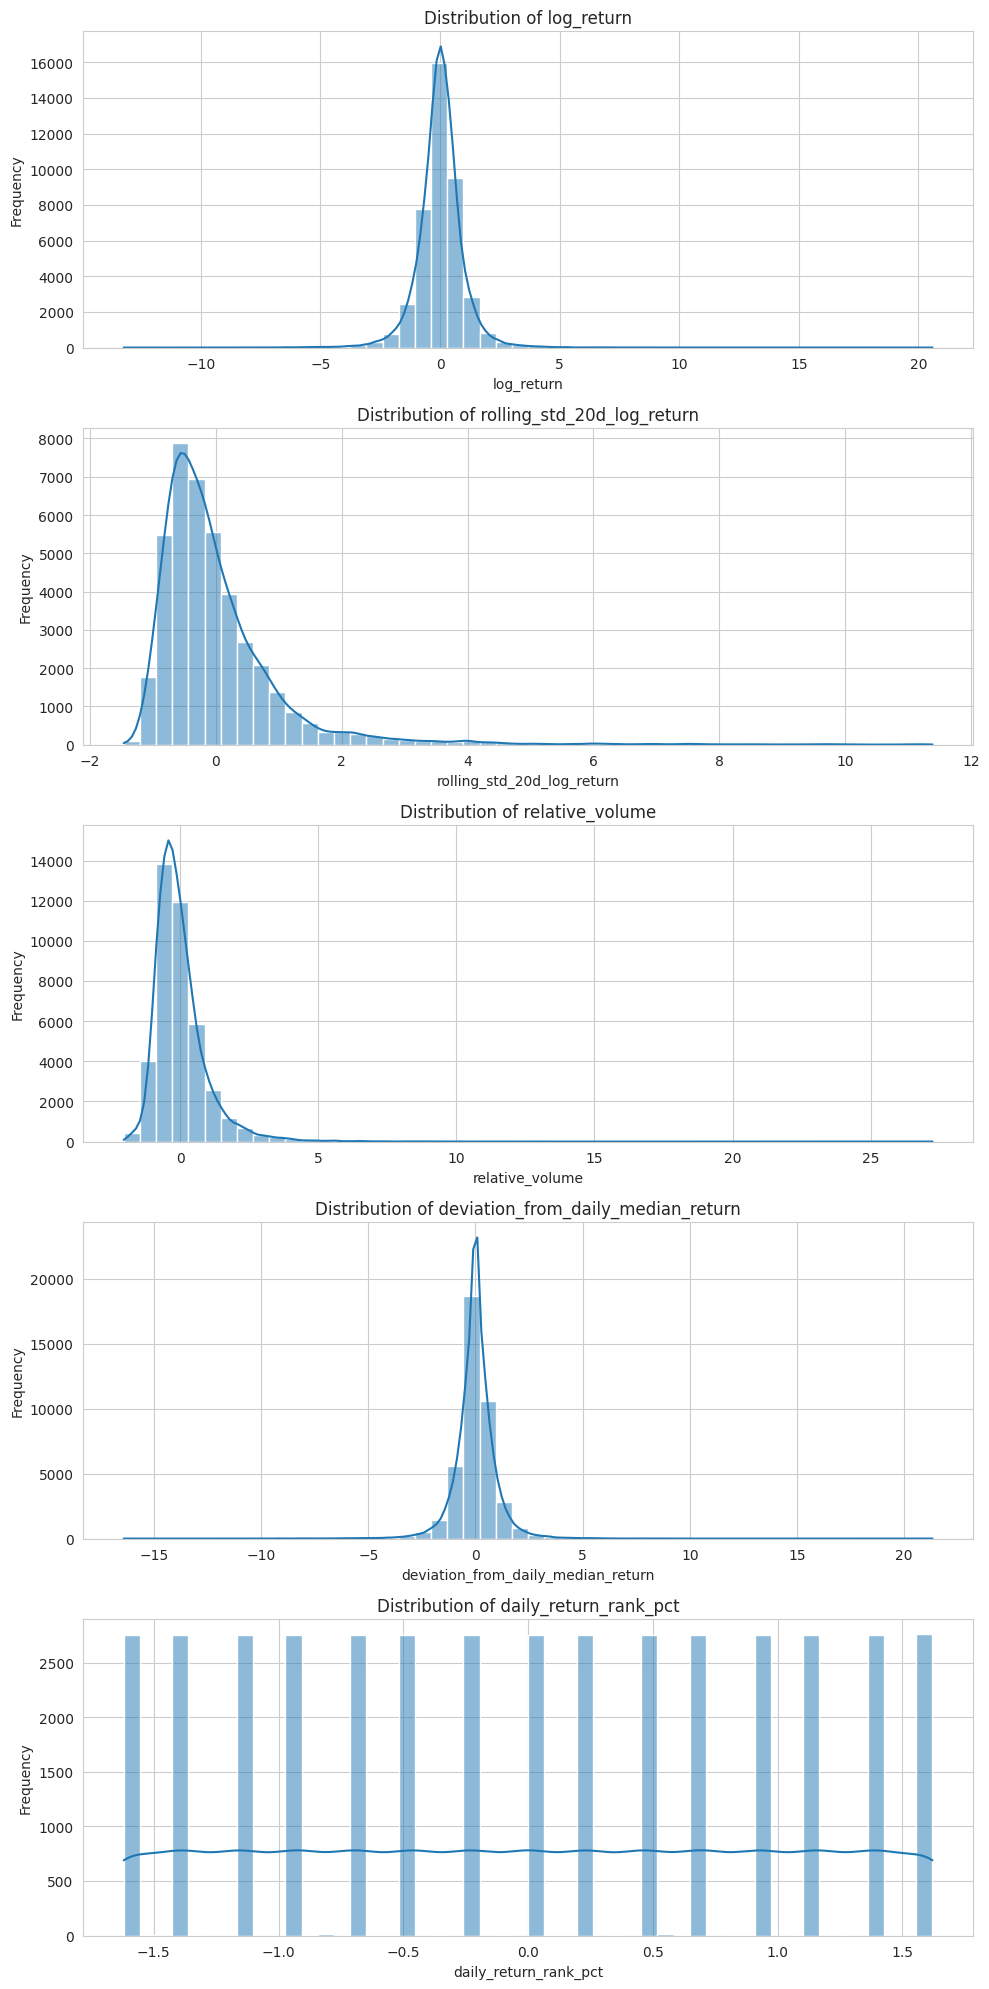


3. Time Series Plots for 3 Sample Tickers:


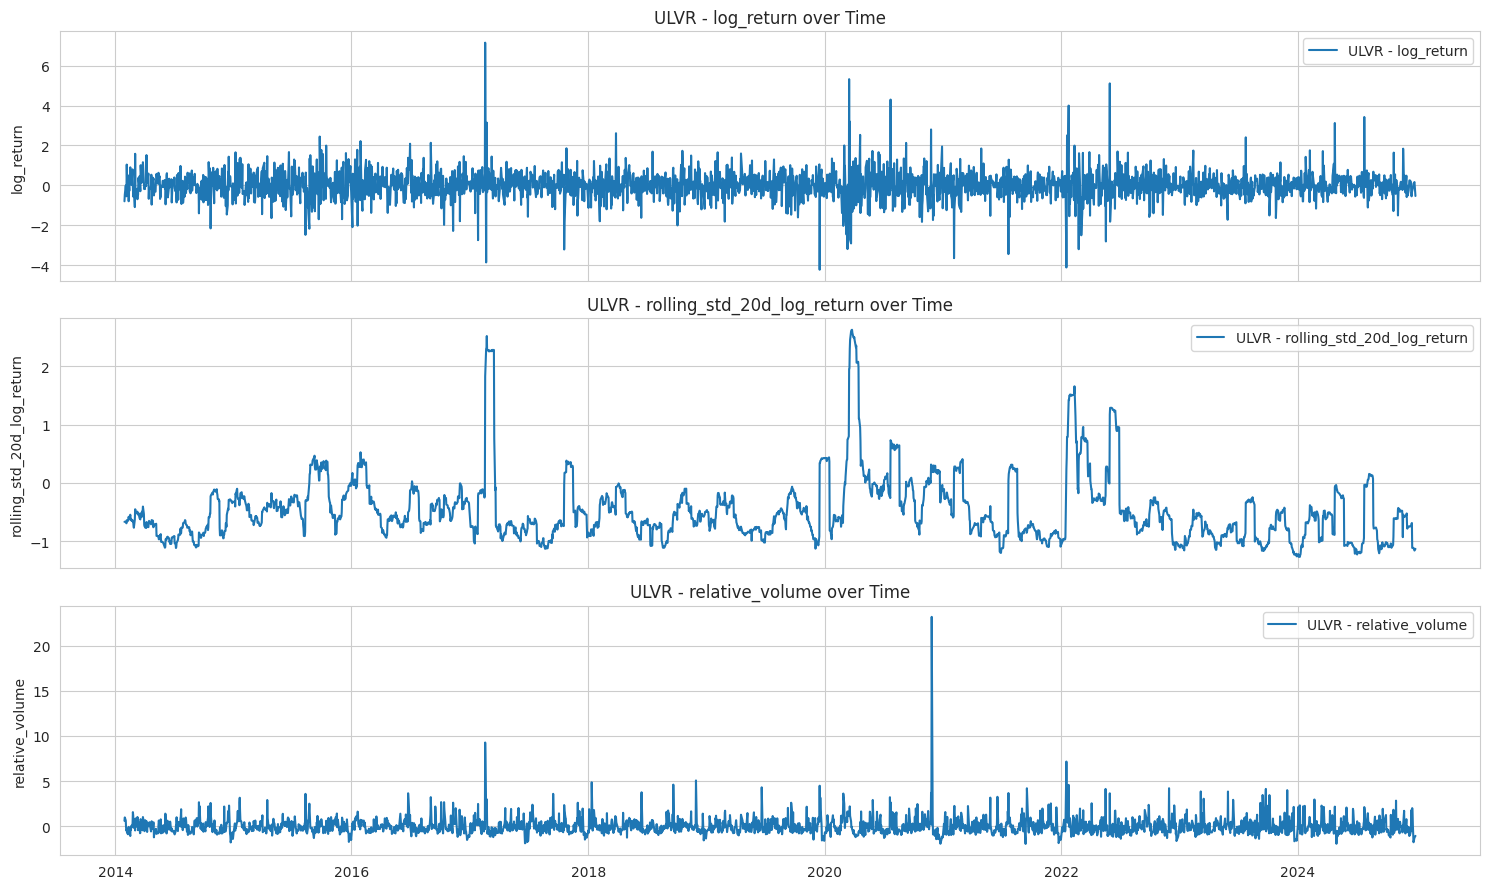

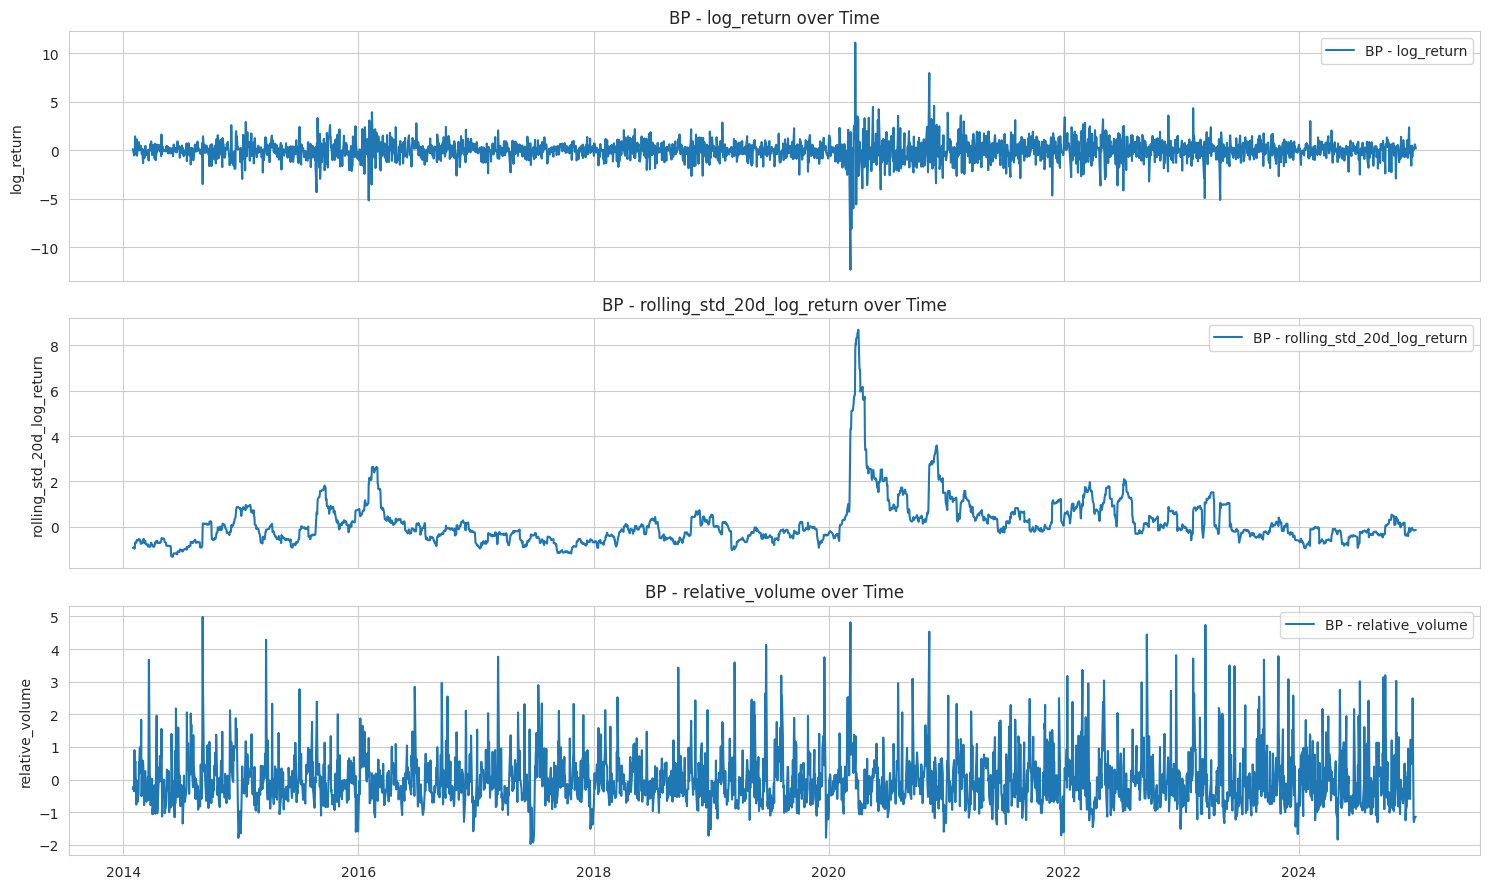

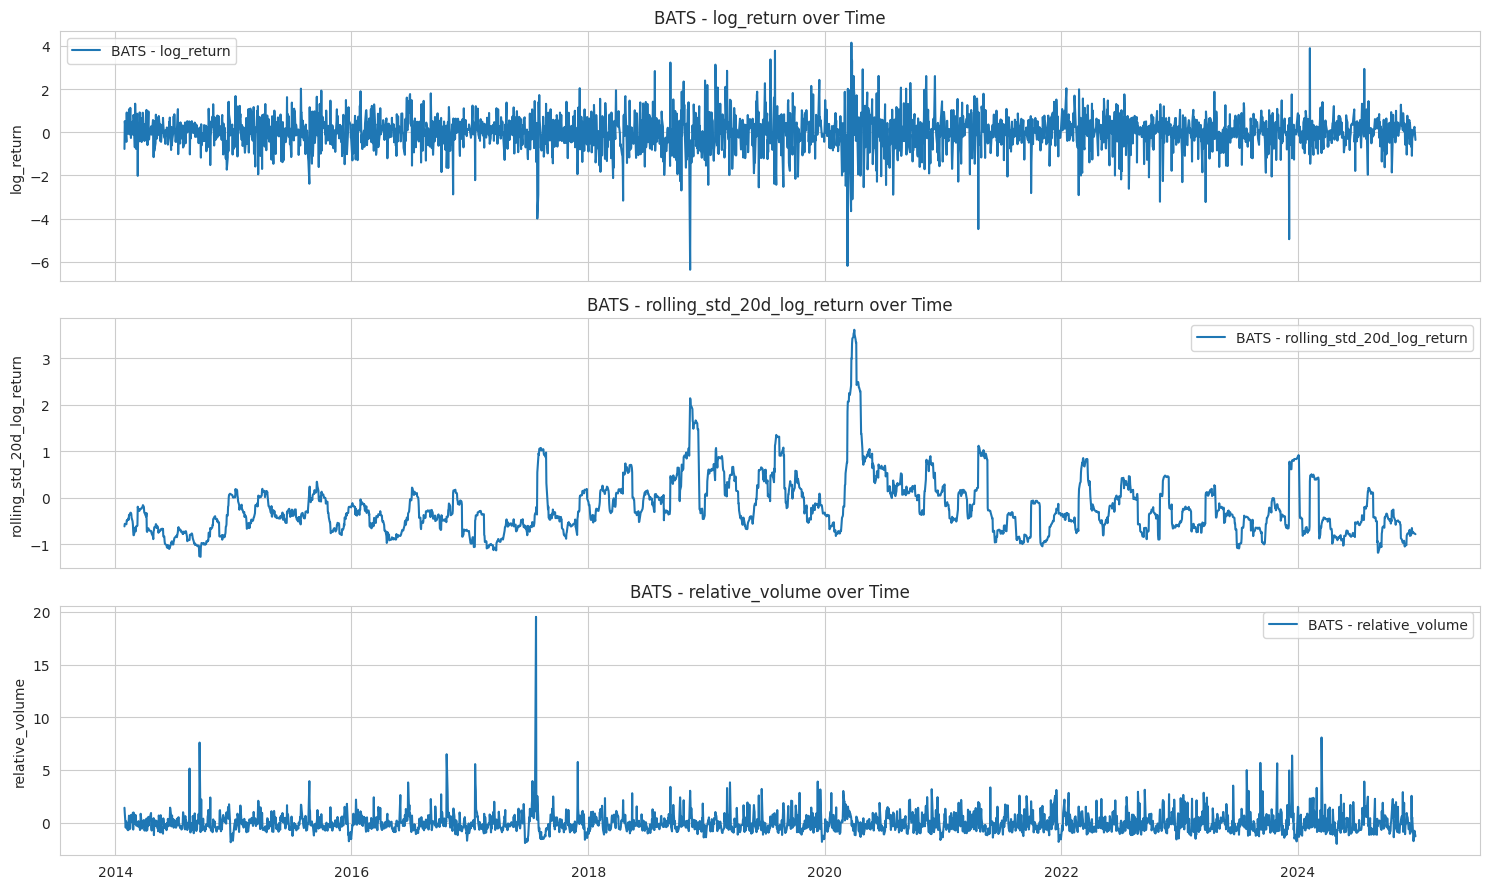


4. Correlation Matrix (Top 15 Most Correlated Features):


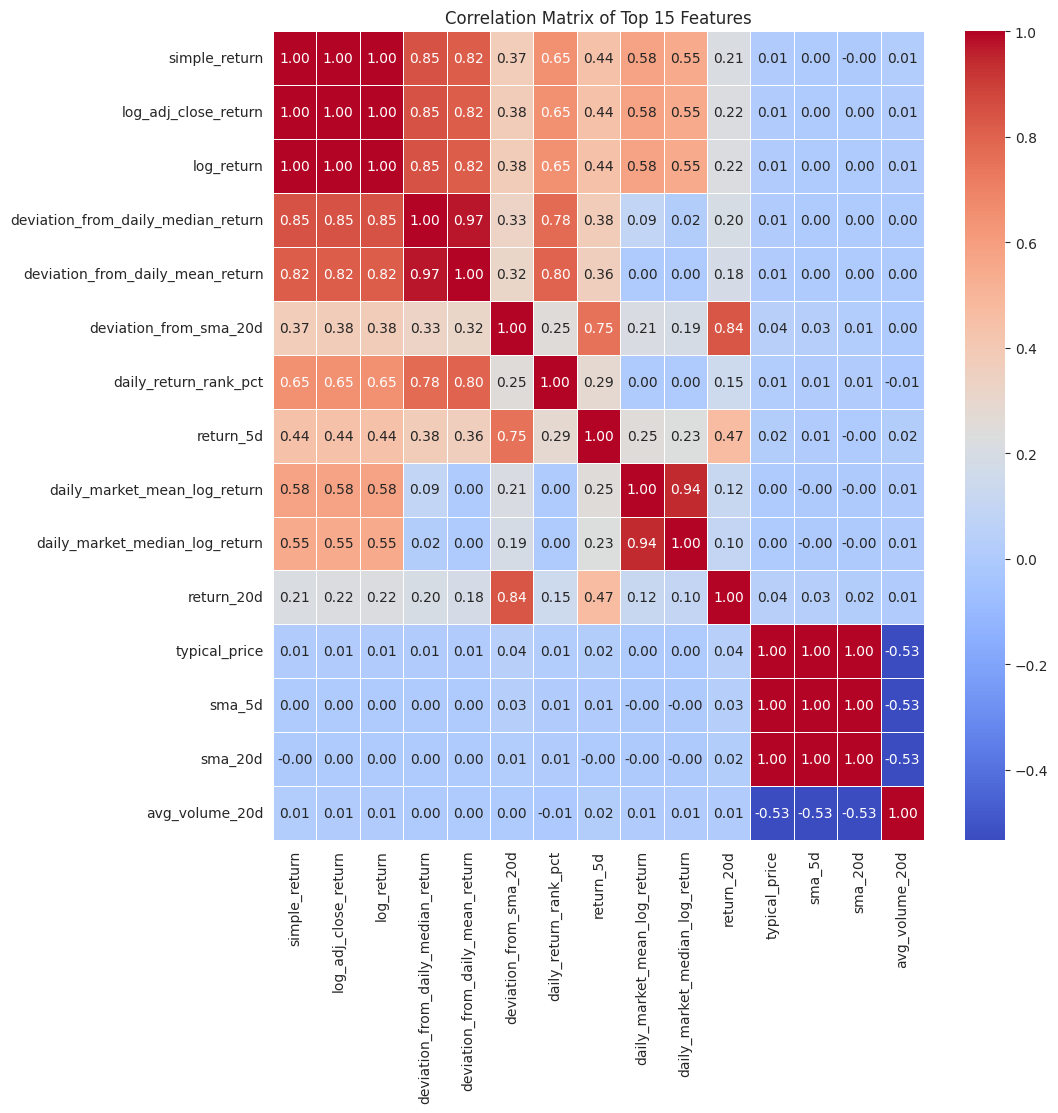


5. Box Plots of All Features:


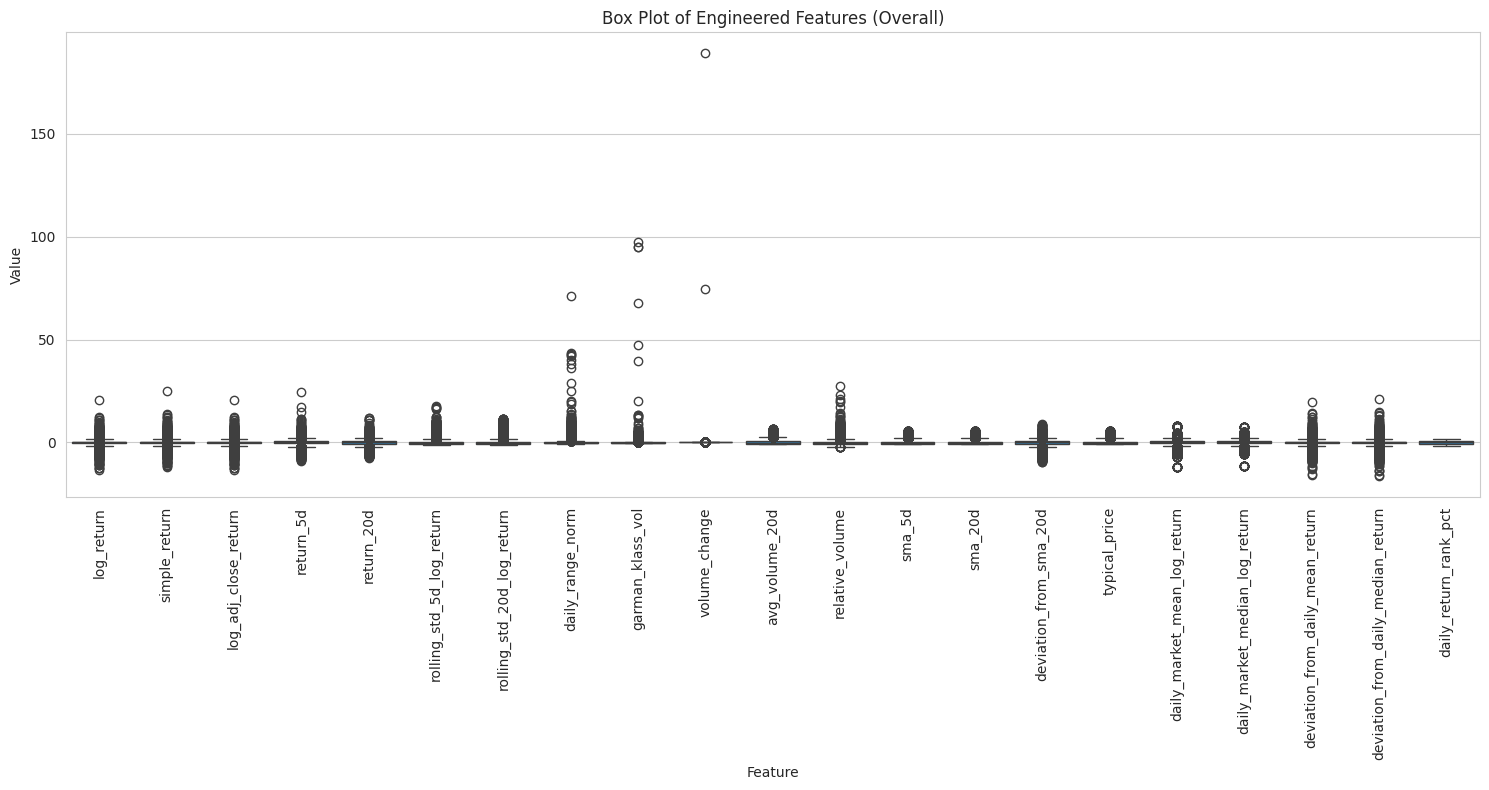


6. Pair Plots for a subset of features (Warning: Can be very slow for many features/rows):
⚠️ Too many rows for pair plot (sampling for speed). Skipped pair plot due to potentially large data.

--- Data Visualization Complete ---


In [18]:
# Data visualization


def visualize_engineered_features(df: pd.DataFrame, num_sample_tickers: int = 3, num_top_features_corr: int = 15):
    """
    Generates various visualizations for the engineered stock features.

    Assumes input DataFrame has a MultiIndex (Date, Ticker) and contains
    numerical features (optionally scaled).

    Args:
        df (pd.DataFrame): The DataFrame with engineered features, MultiIndex (Date, Ticker).
        num_sample_tickers (int): Number of random tickers to sample for time-series plots.
                                  Defaults to 3.
        num_top_features_corr (int): Number of top correlated features to display in the
                                     correlation heatmap. Defaults to 15.
    """
    if df.empty:
        print("DataFrame is empty. No visualizations to generate.")
        return

    print("\n--- Starting Data Visualization for Engineered Features ---")

    # Set plot style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

    # --- 1. Overall DataFrame Information ---
    print("\n1. DataFrame Overview:")
    print(f"Total entries: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")
    print(f"Number of unique tickers: {df.index.get_level_values('Ticker').nunique()}")
    print(f"Date range: {df.index.get_level_values('Date').min().date()} to {df.index.get_level_values('Date').max().date()}")

    # --- 2. Distribution of Key Features ---
    print("\n2. Distribution of Selected Key Features (Histograms/KDE):")
    # Select a few representative features to visualize their distribution
    # Adjust these feature names based on your actual generated features
    key_features = [
        'log_return', 'rolling_std_20d_log_return', 'relative_volume',
        'deviation_from_daily_median_return', 'daily_return_rank_pct'
    ]

    # Filter for features that actually exist in the DataFrame
    existing_key_features = [f for f in key_features if f in df.columns]

    if existing_key_features:
        fig, axes = plt.subplots(len(existing_key_features), 1, figsize=(10, 4 * len(existing_key_features)))
        if len(existing_key_features) == 1: axes = [axes] # Ensure axes is iterable for single plot

        for i, feature in enumerate(existing_key_features):
            sns.histplot(df[feature], kde=True, ax=axes[i], bins=50)
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No key features found to plot distributions. Ensure feature names are correct.")

    # --- 3. Time Series Plots for Sample Tickers ---
    print(f"\n3. Time Series Plots for {num_sample_tickers} Sample Tickers:")
    unique_tickers = df.index.get_level_values('Ticker').unique()
    if len(unique_tickers) > num_sample_tickers:
        sample_tickers = np.random.choice(unique_tickers, num_sample_tickers, replace=False)
    else:
        sample_tickers = unique_tickers # Use all if fewer than requested samples

    features_to_plot_ts = ['log_return', 'rolling_std_20d_log_return', 'relative_volume']
    existing_features_to_plot_ts = [f for f in features_to_plot_ts if f in df.columns]

    if existing_features_to_plot_ts and sample_tickers.size > 0:
        for ticker in sample_tickers:
            ticker_df = df.loc[(slice(None), ticker), :] # Select all dates for this ticker
            ticker_df = ticker_df.droplevel('Ticker') # Drop Ticker level from index for cleaner plot

            fig, axes = plt.subplots(len(existing_features_to_plot_ts), 1, figsize=(15, 3 * len(existing_features_to_plot_ts)), sharex=True)
            if len(existing_features_to_plot_ts) == 1: axes = [axes] # Ensure axes is iterable

            for i, feature in enumerate(existing_features_to_plot_ts):
                if feature in ticker_df.columns:
                    axes[i].plot(ticker_df.index, ticker_df[feature], label=f'{ticker} - {feature}')
                    axes[i].set_title(f'{ticker} - {feature} over Time')
                    axes[i].set_ylabel(feature)
                    axes[i].legend()
            plt.tight_layout()
            plt.show()
    else:
        print("⚠️ Not enough data or features to plot time series for sample tickers.")

    # --- 4. Correlation Matrix of Features ---
    print(f"\n4. Correlation Matrix (Top {num_top_features_corr} Most Correlated Features):")
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Find the top N most correlated features (by sum of absolute correlations)
    # Exclude self-correlation (diagonal) when summing
    np.fill_diagonal(corr_matrix.values, np.nan) # Temporarily set diagonal to NaN for sum
    sum_abs_corr = corr_matrix.abs().sum().sort_values(ascending=False)

    # Restore diagonal for display
    np.fill_diagonal(corr_matrix.values, 1.0)

    top_features = sum_abs_corr.head(num_top_features_corr).index.tolist()

    if len(top_features) > 1:
        plt.figure(figsize=(num_top_features_corr * 0.7, num_top_features_corr * 0.7))
        sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'Correlation Matrix of Top {num_top_features_corr} Features')
        plt.show()
    else:
        print("⚠️ Not enough features or no strong correlations to plot heatmap.")

    # --- 5. Box Plots of Features (Overall) ---
    print("\n5. Box Plots of All Features:")
    plt.figure(figsize=(15, 8))
    # It's better to melt the DataFrame for box plots if you want all features on one plot
    # Or plot each feature individually if the number of features is small
    df_melted = df.reset_index().melt(id_vars=['Date', 'Ticker'], var_name='Feature', value_name='Value')

    # Plotting for numerical features only
    numerical_features_only = df_melted[df_melted['Feature'].isin(df.select_dtypes(include=np.number).columns)]

    if not numerical_features_only.empty:
        sns.boxplot(data=numerical_features_only, x='Feature', y='Value', orient='v')
        plt.title('Box Plot of Engineered Features (Overall)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No numerical features to plot box plots.")

    # --- 6. Pair Plots (for selected features - can be very slow for many features) ---
    print("\n6. Pair Plots for a subset of features (Warning: Can be very slow for many features/rows):")
    # It's impractical to plot all features. Select a very small, representative subset.
    pair_plot_features = [
        'log_return', 'rolling_std_5d_log_return', 'daily_return_rank_pct'
    ]
    existing_pair_plot_features = [f for f in pair_plot_features if f in df.columns]

    if len(existing_pair_plot_features) >= 2 and df.shape[0] < 5000: # Limit for performance
        print(f"Plotting pair plots for: {', '.join(existing_pair_plot_features)}. This may take a while.")
        sns.pairplot(df[existing_pair_plot_features].sample(min(500, df.shape[0]))) # Sample a subset for faster plotting
        plt.suptitle('Pair Plots of Selected Features', y=1.02)
        plt.show()
    elif len(existing_pair_plot_features) < 2:
        print("⚠️ Not enough selected features for pair plot.")
    else:
        print("⚠️ Too many rows for pair plot (sampling for speed). Skipped pair plot due to potentially large data.")


    print("\n--- Data Visualization Complete ---")

# Call the visualization function
visualize_engineered_features(final_processed_FTSE100_df)

In [19]:
# A function to split data into training and validation

def perform_chronological_split(df: pd.DataFrame, split_date: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the input DataFrame into training and evaluation sets based on a chronological date.

    The training set will contain data up to and including the split_date.
    The evaluation set will contain data strictly after the split_date.

    Args:
        df (pd.DataFrame): The input DataFrame with a MultiIndex (Date, Ticker),
                           and numerical features. This is your 'processed_features_df'.
        split_date (str): The date string in 'YYYY-MM-DD' format to use as the split point.
                          Data up to this date goes into the training set.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The training data (X_train_normal).
            - pd.DataFrame: The evaluation data (X_eval).
            Returns empty DataFrames if the input is empty or split is not possible.
    """
    if df.empty:
        print("Input DataFrame is empty for chronological split. Returning empty DataFrames.")
        return pd.DataFrame(), pd.DataFrame()

    try:
        parsed_split_date = pd.to_datetime(split_date)
    except ValueError:
        print(f"❌ Error: Invalid split_date format '{split_date}'. Please use 'YYYY-MM-DD'.")
        return pd.DataFrame(), pd.DataFrame()

    print(f"\n--- Performing Chronological Data Split at {parsed_split_date.date()} ---")

    # X_train_normal: Data from the beginning up to the split_date (inclusive)
    X_train_normal = df.loc[df.index.get_level_values('Date') <= parsed_split_date].copy()

    # X_eval: Data strictly after the split_date
    X_eval = df.loc[df.index.get_level_values('Date') > parsed_split_date].copy()

    print(f"Data split complete:")
    print(f"  Training data (X_train_normal) shape: {X_train_normal.shape} (Dates up to {parsed_split_date.date()})")
    print(f"  Evaluation data (X_eval) shape: {X_eval.shape} (Dates after {parsed_split_date.date()})")

    # Basic verification of the split
    if not X_train_normal.empty and not X_eval.empty:
        max_train_date = X_train_normal.index.get_level_values('Date').max()
        min_eval_date = X_eval.index.get_level_values('Date').min()
        print(f"  Verification: Max train date: {max_train_date.date()}, Min eval date: {min_eval_date.date()}")
        if max_train_date >= parsed_split_date and min_eval_date <= parsed_split_date: # This condition might be too strict if split_date is not present in data
            pass # The check is more about ensuring non-overlap in the general sense.
    elif X_train_normal.empty:
        print("⚠️ Warning: Training data is empty after split. Check split_date or input data.")
    elif X_eval.empty:
        print("⚠️ Warning: Evaluation data is empty after split. Check split_date or input data.")


    return X_train_normal, X_eval


In [20]:
# Calling the function to split the data into training and testing

# Define your desired chronological split point (e.g., end of 2020)
# A common split is 70-80% for training. For 2014-2024 data, 2020-12-31 is a good point.
my_split_date = "2020-12-31"

# Call the function to perform the split on the FTSE 100 stocks
X1_train_normal, X1_eval = perform_chronological_split(final_processed_FTSE100_df, my_split_date)

#Call the function to perform the split on the FTSE 250 stocks
X2_train_normal, X2_eval = perform_chronological_split(final_processed_FTSE250_df, my_split_date)




--- Performing Chronological Data Split at 2020-12-31 ---
Data split complete:
  Training data (X_train_normal) shape: (26261, 21) (Dates up to 2020-12-31)
  Evaluation data (X_eval) shape: (15104, 21) (Dates after 2020-12-31)
  Verification: Max train date: 2020-12-31, Min eval date: 2021-01-04

--- Performing Chronological Data Split at 2020-12-31 ---
Data split complete:
  Training data (X_train_normal) shape: (24060, 21) (Dates up to 2020-12-31)
  Evaluation data (X_eval) shape: (15104, 21) (Dates after 2020-12-31)
  Verification: Max train date: 2020-12-31, Min eval date: 2021-01-04


In [21]:
# A function to train the data using the Isolation Forest Model

def train_and_score_isolation_forest(
    X_train_normal: pd.DataFrame,
    X_eval: pd.DataFrame,
    contamination: float = 0.01,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, IsolationForest]:
    """
    Trains an Isolation Forest model on X_train_normal and applies it to
    both X_train_normal and X_eval to generate anomaly scores and labels.

    Args:
        X_train_normal (pd.DataFrame): DataFrame containing the features for training
                                       the Isolation Forest model (assumed to be scaled).
        X_eval (pd.DataFrame): DataFrame containing the features for evaluating
                               the trained model (assumed to be scaled).
        contamination (float): The proportion of outliers in the data set.
                               Used to define the threshold for anomaly prediction.
                               Defaults to 0.01 (1%).
        random_state (int): Seed for reproducibility of the Isolation Forest model.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: X_train_normal with 'anomaly_score' and 'anomaly_label' columns added.
            - pd.DataFrame: X_eval with 'anomaly_score' and 'anomaly_label' columns added.
            - IsolationForest: The trained Isolation Forest model.
        Returns empty DataFrames and None if input is empty.
    """
    if X_train_normal.empty:
        print("X_train_normal is empty. Cannot train Isolation Forest.")
        return pd.DataFrame(), pd.DataFrame(), None
    if X_eval.empty:
        print("X_eval is empty. Cannot score Isolation Forest on evaluation set.")
        # We can still train and score on train, but will return empty X_eval_scored

    print("\n--- Training and Scoring Isolation Forest Model ---")

    # Initialize and train the Isolation Forest model
    # Isolation Forest does not technically need scaled data, but it's good practice
    # as it's often followed by other models sensitive to scaling.
    print(f"Training Isolation Forest with contamination={contamination} and random_state={random_state}...")
    iso_forest_model = IsolationForest(contamination=contamination, random_state=random_state)
    iso_forest_model.fit(X_train_normal)
    print("Isolation Forest model trained successfully.")

    # --- Apply the model to generate scores and labels ---

    # Score and label X_train_normal
    print("Generating anomaly scores and labels for X_train_normal...")
    X_train_normal_scored = X_train_normal.copy()
    X_train_normal_scored['iso_forest_anomaly_score'] = iso_forest_model.decision_function(X_train_normal)
    # predict returns -1 for outliers and 1 for inliers
    X_train_normal_scored['iso_forest_anomaly_label'] = iso_forest_model.predict(X_train_normal)
    # Map to 0 (normal) and 1 (anomaly) for easier interpretation
    X_train_normal_scored['iso_forest_is_anomaly'] = X_train_normal_scored['iso_forest_anomaly_label'].map({1: 0, -1: 1})
    print("Anomaly scores and labels generated for X_train_normal.")

    # Score and label X_eval
    X_eval_scored = X_eval.copy()
    if not X_eval.empty:
        print("Generating anomaly scores and labels for X_eval...")
        X_eval_scored['iso_forest_anomaly_score'] = iso_forest_model.decision_function(X_eval)
        X_eval_scored['iso_forest_anomaly_label'] = iso_forest_model.predict(X_eval)
        X_eval_scored['iso_forest_is_anomaly'] = X_eval_scored['iso_forest_anomaly_label'].map({1: 0, -1: 1})
        print("Anomaly scores and labels generated for X_eval.")
    else:
        print("X_eval is empty, skipping anomaly scoring for evaluation set.")

    print("--- Isolation Forest Training and Scoring Complete ---")

    return X_train_normal_scored, X_eval_scored, iso_forest_model



In [22]:
# Calling the Train and score the Isolation Forest model on the FTSE 100 stocks

X100_train_normal_iso_scored, X100_eval_iso_scored, isolation_model = \
    train_and_score_isolation_forest(X1_train_normal.copy(), X1_eval.copy(), contamination=0.01)

# Display results
if not X100_train_normal_iso_scored.empty:
    print("\n--- X_train_normal (Isolation Forest Scored) Head ---")
    print(X100_train_normal_iso_scored.head())
    print("\nAnomaly counts in X_train_normal:")
    print(X100_train_normal_iso_scored['iso_forest_is_anomaly'].value_counts())

if not X100_eval_iso_scored.empty:
    print("\n--- X_eval (Isolation Forest Scored) Head ---")
    print(X100_eval_iso_scored.head())
    print("\nAnomaly counts in X_eval:")
    print(X100_eval_iso_scored['iso_forest_is_anomaly'].value_counts())

print("\nIsolation Forest Model Summary:")
print(isolation_model)


--- Training and Scoring Isolation Forest Model ---
Training Isolation Forest with contamination=0.01 and random_state=42...
Isolation Forest model trained successfully.
Generating anomaly scores and labels for X_train_normal...
Anomaly scores and labels generated for X_train_normal.
Generating anomaly scores and labels for X_eval...
Anomaly scores and labels generated for X_eval.
--- Isolation Forest Training and Scoring Complete ---

--- X_train_normal (Isolation Forest Scored) Head ---
                   log_return  simple_return  log_adj_close_return  return_5d  return_20d  rolling_std_5d_log_return  rolling_std_20d_log_return  daily_range_norm  garman_klass_vol  volume_change  avg_volume_20d  relative_volume    sma_5d   sma_20d  deviation_from_sma_20d  typical_price  daily_market_mean_log_return  daily_market_median_log_return  deviation_from_daily_mean_return  deviation_from_daily_median_return  daily_return_rank_pct  iso_forest_anomaly_score  iso_forest_anomaly_label  iso_fores

In [23]:
# Filter the DataFrame to show only the anomalous data points
anomalies_df = X100_eval_iso_scored[X100_eval_iso_scored['iso_forest_is_anomaly'] == 1]

print(f"\n--- Detected Anomalies (Total: {anomalies_df.shape[0]}) ---")
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.width', 1000)      # Ensure wide display
print(anomalies_df.sort_values(by='iso_forest_anomaly_score').head(20)) # Show the top 10 most anomalous (lowest score)



--- Detected Anomalies (Total: 65) ---
                   log_return  simple_return  log_adj_close_return  return_5d  return_20d  rolling_std_5d_log_return  rolling_std_20d_log_return  daily_range_norm  garman_klass_vol  volume_change  avg_volume_20d  relative_volume    sma_5d   sma_20d  deviation_from_sma_20d  typical_price  daily_market_mean_log_return  daily_market_median_log_return  deviation_from_daily_mean_return  deviation_from_daily_median_return  daily_return_rank_pct  iso_forest_anomaly_score  iso_forest_anomaly_label  iso_forest_is_anomaly
Date       Ticker                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:

# --- NEW MERGE LOGIC FOR ULTIMATE ROBUSTNESS (using index-based merge) ---

# 1. Prepare original_eval_data: filter by date range and ensure unique MultiIndex
eval_start_date = X100_eval_iso_scored.index.get_level_values('Date').min()
eval_end_date = X100_eval_iso_scored.index.get_level_values('Date').max()

original_eval_data_for_merge = ready_ftse100_data.loc[
    (ready_ftse100_data.index.get_level_values('Date') >= eval_start_date) &
    (ready_ftse100_data.index.get_level_values('Date') <= eval_end_date)
].copy()

# Crucial: Drop duplicates from the MultiIndex if any exist, before any merge operations.
# The .index.duplicated() check is robust for MultiIndex.
if not original_eval_data_for_merge.index.is_unique:
    print("Warning: Duplicates found in original_eval_data_for_merge index. Dropping them.")
    original_eval_data_for_merge = original_eval_data_for_merge[~original_eval_data_for_merge.index.duplicated(keep='first')].copy()

# 2. Prepare X100_eval_iso_scored (features and scores): ensure unique MultiIndex
if not X100_eval_iso_scored.index.is_unique:
    print("Warning: Duplicates found in X100_eval_iso_scored index. Dropping them.")
    X100_eval_iso_scored_unique = X100_eval_iso_scored[~X100_eval_iso_scored.index.duplicated(keep='first')].copy()
else:
    X100_eval_iso_scored_unique = X100_eval_iso_scored.copy()


# Ensure that both DataFrames have the same index for a clean merge (intersection)
# This will align them perfectly based on (Date, Ticker)
common_indices = original_eval_data_for_merge.index.intersection(X100_eval_iso_scored_unique.index)

original_eval_data_aligned = original_eval_data_for_merge.loc[common_indices]
eval_scores_features_aligned = X100_eval_iso_scored_unique.loc[common_indices]


# 3. Perform the merge using `left_index=True` and `right_index=True`
#    This merges directly on the MultiIndex, which is the most stable approach.
#    We are merging the features and anomaly data from eval_scores_features_aligned
#    onto the original raw data from original_eval_data_aligned.

# Columns to take from eval_scores_features_aligned (all columns except base data)
cols_to_merge_from_scores = [col for col in eval_scores_features_aligned.columns
                             if col not in original_eval_data_aligned.columns or col in ['iso_forest_anomaly_score', 'iso_forest_anomaly_label', 'iso_forest_is_anomaly']]

full_eval_data_with_anomalies = original_eval_data_aligned.merge(
    eval_scores_features_aligned[cols_to_merge_from_scores],
    left_index=True,  # Merge on the index of the left DataFrame
    right_index=True, # Merge on the index of the right DataFrame
    how='left'        # Keep all rows from the left DataFrame (original data)
)

print(f"Full eval data with anomalies shape: {full_eval_data_with_anomalies.shape}")
print(f"Is index truly unique in full_eval_data_with_anomalies? {full_eval_data_with_anomalies.index.is_unique}") # Should be True

# --- Step 1: Filter to See Only the Anomalies from the NEW Merged DataFrame ---
# This filtering now happens on a DataFrame guaranteed to have a unique MultiIndex.
anomalies_df = full_eval_data_with_anomalies[full_eval_data_with_anomalies['iso_forest_is_anomaly'] == 1].copy()

print(f"\n--- Detected Anomalies with Original Context (Total: {anomalies_df.shape[0]}) ---")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(anomalies_df.sort_values(by='iso_forest_anomaly_score').head(10))


# --- Step 2: Inspect Anomaly Characteristics ---
# Review anomalies_df to understand specific values.


# --- Step 3: Visualize Individual Anomalies in Context ---
print("\n--- Visualizing Individual Anomalies with Original Close Price Context ---")

window_days = 30

if not anomalies_df.empty:
    sample_anomaly_indices = anomalies_df.sort_values(by='iso_forest_anomaly_score').head(3).index.tolist()
else:
    sample_anomaly_indices = []
    print("No anomalies detected to visualize.")

for anomaly_idx in sample_anomaly_indices:
    anomaly_date = anomaly_idx[0]
    anomaly_ticker = anomaly_idx[1]

    print(f"\nVisualizing anomaly for {anomaly_ticker} on {anomaly_date.date()}")

    # Select data for this specific ticker across a time window from the full_eval_data_with_anomalies
    # This DataFrame should already have its MultiIndex intact and unique.
    ticker_data_for_plot = full_eval_data_with_anomalies.loc[(slice(None), anomaly_ticker), :].droplevel('Ticker')

    start_window = anomaly_date - pd.Timedelta(days=window_days)
    end_window = anomaly_date + pd.Timedelta(days=window_days)

    plot_data = ticker_data_for_plot.loc[start_window:end_window]

    if plot_data.empty:
        print(f"No data available for {anomaly_ticker} around {anomaly_date.date()} for plotting window.")
        continue

    plt.figure(figsize=(15, 8))

    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(plot_data.index, plot_data['close'], label=f'{anomaly_ticker} Close Price', color='blue')

    anomalies_in_window = plot_data[plot_data['iso_forest_is_anomaly'] == 1]
    if not anomalies_in_window.empty:
        ax1.scatter(anomalies_in_window.index, anomalies_in_window['close'],
                    color='red', s=100, zorder=5, label='Detected Anomaly')

    ax1.set_title(f'Close Price for {anomaly_ticker} around {anomaly_date.date()}')
    ax1.set_ylabel('Close Price')
    ax1.legend()
    ax1.grid(True)

    ax2 = plt.subplot(3, 1, 2, sharex=ax1)
    if 'log_return' in plot_data.columns:
        ax2.plot(plot_data.index, plot_data['log_return'], label=f'{anomaly_ticker} Log Return', color='green')
        if not anomalies_in_window.empty:
            ax2.scatter(anomalies_in_window.index, anomalies_in_window['log_return'], color='red', s=100, zorder=5)
        ax2.set_ylabel('Log Return')
        ax2.set_title(f'Log Return for {anomaly_ticker} around {anomaly_date.date()}')
        ax2.legend()
        ax2.grid(True)
    elif 'relative_volume' in plot_data.columns:
        ax2.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
        if not anomalies_in_window.empty:
            ax2.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
        ax2.set_ylabel('Relative Volume')
        ax2.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
        ax2.legend()
        ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, "No suitable feature for second plot.", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


    ax3 = plt.subplot(3, 1, 3, sharex=ax1)
    if 'relative_volume' in plot_data.columns:
        ax3.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
        if not anomalies_in_window.empty:
            ax3.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
        ax3.set_ylabel('Relative Volume')
        ax3.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
    elif 'deviation_from_daily_median_return' in plot_data.columns:
         ax3.plot(plot_data.index, plot_data['deviation_from_daily_median_return'], label=f'{anomaly_ticker} Deviation from Median Daily Return', color='orange')
         if not anomalies_in_window.empty:
            ax3.scatter(anomalies_in_window.index, anomalies_in_window['deviation_from_daily_median_return'], color='red', s=100, zorder=5)
         ax3.set_ylabel('Deviation from Median Daily Return')
         ax3.set_title(f'Deviation from Median Daily Return for {anomaly_ticker} around {anomaly_date.date()}')
    else:
        ax3.text(0.5, 0.5, "No suitable feature for third plot.", horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)

    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:


def analyze_and_visualize_anomalies(
    anomalies_df_multiindex: pd.DataFrame, # Now explicitly named as MultiIndex input
    full_eval_data_with_anomalies_multiindex: pd.DataFrame, # Now explicitly named as MultiIndex input
    num_top_anomalies_to_plot: int = 5,
    window_days_for_plot: int = 40 # Days before and after anomaly for time-series plot
):
    """
    Performs detailed analysis and visualization of detected anomalies.

    Args:
        anomalies_df_multiindex (pd.DataFrame): DataFrame containing only the data points
                                               identified as anomalies (from Isolation Forest).
                                               Must have MultiIndex (Date, Ticker).
        full_eval_data_with_anomalies_multiindex (pd.DataFrame): The complete evaluation DataFrame
                                                                 with all features, original data,
                                                                 and anomaly scores/labels (both normal and anomalous points).
                                                                 Must have MultiIndex (Date, Ticker).
        num_top_anomalies_to_plot (int): Number of top (most anomalous) events to plot in detail.
        window_days_for_plot (int): Number of calendar days before and after an anomaly
                                    to show in time-series plots for context.
    """
    if anomalies_df_multiindex.empty:
        print("No anomalies detected. Skipping analysis and visualization.")
        return

    print("\n--- Starting Anomaly Analysis and Visualization ---")

    # Set display options for full column view in print statements
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    sns.set_style("whitegrid")

    # --- CRITICAL FIX: Flatten DataFrames to have Date/Ticker as regular columns ---
    # This makes subsequent operations (feature selection, plotting) much more consistent.
    full_eval_data_flat = full_eval_data_with_anomalies_multiindex.reset_index().copy()
    anomalies_df_flat = anomalies_df_multiindex.reset_index().copy()

    # --- 1. Overall Anomaly Summary ---
    total_anomalies = anomalies_df_flat.shape[0] # Use the flattened version here
    print(f"\n1. Overall Anomaly Summary:")
    print(f"Total anomalies detected: {total_anomalies}")

    print("\nTop 10 Tickers with Most Anomalies:")
    print(anomalies_df_flat['Ticker'].value_counts().head(10)) # Use Ticker column from flat DF

    print("\nMost Anomalous Events (Top 10 by Score - Lower is More Anomalous):")
    # Sort on the flat DF, but we'll print using the MultiIndexed df for consistency with previous user output.
    # So, use anomalies_df_multiindex here.
    print(anomalies_df_multiindex.sort_values(by='iso_forest_anomaly_score').head(10))

    # --- 2. Distribution of Anomaly Scores (for Anomalies Only) ---
    plt.figure(figsize=(10, 6))
    sns.histplot(anomalies_df_flat['iso_forest_anomaly_score'], kde=True, bins=30, color='red')
    plt.title('Distribution of Anomaly Scores for Detected Anomalies')
    plt.xlabel('Anomaly Score (Lower = More Anomalous)')
    plt.ylabel('Count')
    plt.show()

    # --- 3. Feature Comparison: Anomalies vs. Normal Data (Box Plots) ---
    print("\n3. Feature Comparison: Anomalies vs. Normal Data (Box Plots):")

    # Corrected way to get feature columns when DataFrame has a flat index and Date/Ticker are columns
    # Get all numerical columns that are NOT Date, Ticker, or anomaly scores/labels, or original base columns.
    feature_cols = [col for col in full_eval_data_flat.columns
                    if pd.api.types.is_numeric_dtype(full_eval_data_flat[col]) # Ensure numerical
                    and col not in ['Date', 'Ticker', 'iso_forest_anomaly_score', 'iso_forest_anomaly_label', 'iso_forest_is_anomaly']
                    and col not in ['open', 'high', 'low', 'close', 'adj close', 'volume']] # Exclude raw original data if desired

    # Select a diverse sample of actual features for comparison
    comparison_features = ['log_return', 'rolling_std_20d_log_return', 'relative_volume', 'deviation_from_daily_median_return']
    existing_comparison_features = [f for f in comparison_features if f in feature_cols]

    if not existing_comparison_features:
        # Fallback: if specific features aren't found, pick first few numerical features
        existing_comparison_features = feature_cols[:min(5, len(feature_cols))]
        print(f"⚠️ Using a fallback list of {len(existing_comparison_features)} features for comparison plots.")

    if not existing_comparison_features:
        print("⚠️ No suitable features found for comparison plots after all filters. Skipping.")
    else:
        # Use the flattened DataFrame directly for plotting box plots
        fig, axes = plt.subplots(len(existing_comparison_features), 1, figsize=(12, 5 * len(existing_comparison_features)))
        if len(existing_comparison_features) == 1: axes = [axes] # Ensure axes is iterable for single plot

        for i, feature in enumerate(existing_comparison_features):
            sns.boxplot(x='iso_forest_is_anomaly', y=feature, data=full_eval_data_flat, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature} for Normal (0) vs. Anomaly (1)')
            axes[i].set_xlabel('Is Anomaly (0=Normal, 1=Anomaly)')
            axes[i].set_ylabel(feature)
        plt.tight_layout()
        plt.show()

    # --- 4. Anomaly Frequency Over Time ---
    print("\n4. Anomaly Frequency Over Time:")
    # Use the flat DataFrame for value_counts on the 'Date' column
    anomalies_per_day = anomalies_df_flat['Date'].value_counts().sort_index()
    if not anomalies_per_day.empty:
        plt.figure(figsize=(15, 6))
        anomalies_per_day.plot(kind='line', marker='o', linestyle='-', color='red')
        plt.title('Number of Anomalies Detected Per Day')
        plt.xlabel('Date')
        plt.ylabel('Number of Anomalies')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No daily anomaly counts to plot.")

    # --- 5. Detailed Time-Series Plots for Top N Anomalies ---
    print(f"\n5. Detailed Time-Series Plots for Top {num_top_anomalies_to_plot} Anomalies:")

    # Get the indices (Date, Ticker) of the top N most anomalous points from the original MultiIndex anomalies_df
    top_anomaly_indices = anomalies_df_multiindex.sort_values(by='iso_forest_anomaly_score').head(num_top_anomalies_to_plot).index.tolist()

    if not top_anomaly_indices:
        print("No top anomalies to plot in detail.")
        return

    # Use the flattened full_eval_data_flat for plotting, as it has Date/Ticker as columns
    plot_source_df_flat = full_eval_data_flat.copy()

    # Ensure essential plot columns exist
    required_plot_cols = ['close', 'log_return', 'relative_volume']
    if not all(col in plot_source_df_flat.columns for col in required_plot_cols):
        print(f"Error: Missing one or more required plotting columns ({', '.join(required_plot_cols)}) in the main DataFrame. Skipping detailed plots.")
        return

    for anomaly_idx in tqdm(top_anomaly_indices, desc="Plotting Top Anomalies"):
        anomaly_date = anomaly_idx[0]
        anomaly_ticker = anomaly_idx[1]

        print(f"\nVisualizing anomaly for {anomaly_ticker} on {anomaly_date.date()}")

        # Filter the flat DataFrame for plotting by Date and Ticker columns
        ticker_data_for_plot_flat = plot_source_df_flat[
            (plot_source_df_flat['Ticker'] == anomaly_ticker) &
            (plot_source_df_flat['Date'] >= (anomaly_date - pd.Timedelta(days=window_days_for_plot))) &
            (plot_source_df_flat['Date'] <= (anomaly_date + pd.Timedelta(days=window_days_for_plot)))
        ].copy()

        # Temporarily set index to Date for plotting, as plot functions usually prefer this
        plot_data = ticker_data_for_plot_flat.set_index('Date').sort_index()

        if plot_data.empty:
            print(f"No data available for {anomaly_ticker} around {anomaly_date.date()} for plotting window. Skipping.")
            continue

        plt.figure(figsize=(15, 10))

        # Subplot 1: Close Price with Anomaly Highlight
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(plot_data.index, plot_data['close'], label=f'{anomaly_ticker} Close Price', color='blue')

        anomalies_in_window = plot_data[plot_data['iso_forest_is_anomaly'] == 1]
        if not anomalies_in_window.empty:
            ax1.scatter(anomalies_in_window.index, anomalies_in_window['close'],
                        color='red', s=100, zorder=5, label='Detected Anomaly')

        ax1.set_title(f'Close Price for {anomaly_ticker} around {anomaly_date.date()}')
        ax1.set_ylabel('Close Price')
        ax1.legend()
        ax1.grid(True)

        # Subplot 2: Log Return with Anomaly Highlight
        ax2 = plt.subplot(3, 1, 2, sharex=ax1) # Share x-axis to align dates
        ax2.plot(plot_data.index, plot_data['log_return'], label=f'{anomaly_ticker} Log Return', color='green')
        if not anomalies_in_window.empty:
            ax2.scatter(anomalies_in_window.index, anomalies_in_window['log_return'], color='red', s=100, zorder=5)
        ax2.set_ylabel('Log Return')
        ax2.set_title(f'Log Return for {anomaly_ticker} around {anomaly_date.date()}')
        ax2.legend()
        ax2.grid(True)

        # Subplot 3: Relative Volume with Anomaly Highlight
        ax3 = plt.subplot(3, 1, 3, sharex=ax1) # Share x-axis to align dates
        ax3.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
        if not anomalies_in_window.empty:
            ax3.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
        ax3.set_ylabel('Relative Volume')
        ax3.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
        ax3.set_xlabel('Date')
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

    print("\n--- Anomaly Analysis and Visualization Complete ---")



# --- Call the analysis function ---
# Pass the correct variables here
analyze_and_visualize_anomalies(anomalies_df, full_eval_data_with_anomalies, num_top_anomalies_to_plot=5)

In [ ]:
analyze_and_visualize_anomalies(anomalies_df,full_eval_data_with_anomalies)